In [18]:
import pandas as pd

In [ ]:
df = pd.read_csv('./')


# Data Visualization Cheatbook — Plot Types & What They Tell Us

This notebook is designed for teaching assistants (TAs) and instructors who want a compact, hands-on guide to common plot types, **how to make them in Python**, and **what insights** they provide.

**You’ll learn:**
- When to use each plot type
- How to build each plot with `matplotlib` (and a little `pandas`/`numpy`)
- How to explain the insights to students
- Common pitfalls and teaching tips

> For consistency: each chart uses **matplotlib** with **one plot per figure** and **no custom color themes**.



## Setup


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display options for dataframes
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)

# For reproducibility of random numbers
rng = np.random.default_rng(42)



## A Small, Realistic Synthetic Dataset

We'll work with a compact dataset that mimics students in a course:
- demographics (`major`, `year`),
- exam scores,
- weekly study hours,
- and a simple time series (weekly quiz averages).

Use these throughout the notebook to show how different plots answer different questions.


In [2]:

n = 200

majors = np.array(['CS', 'Math', 'Physics', 'Biology', 'Economics'])
years = np.array(['Freshman', 'Sophomore', 'Junior', 'Senior'])

data = pd.DataFrame({
    'student_id': np.arange(1, n+1),
    'major': rng.choice(majors, size=n, p=[0.30, 0.20, 0.20, 0.15, 0.15]),
    'year': rng.choice(years, size=n, p=[0.25, 0.25, 0.25, 0.25]),
})

# Generate continuous variables with some correlation
study_hours = rng.normal(10, 3, size=n).clip(0)  # weekly study hours
baseline = 60 + 2*study_hours  # higher hours -> higher scores (trend)
noise = rng.normal(0, 10, size=n)
exam1 = (baseline + noise).clip(0, 100)
exam2 = (0.4*exam1 + baseline*0.6 + rng.normal(0, 8, size=n)).clip(0, 100)

data['study_hours'] = study_hours
data['exam1'] = exam1
data['exam2'] = exam2

# Time series: weekly quiz averages (12 weeks)
weeks = np.arange(1, 13)
quiz_avg = 65 + 1.5*weeks + rng.normal(0, 2.5, size=len(weeks))
quiz_df = pd.DataFrame({'week': weeks, 'avg_quiz_score': quiz_avg})

data.head()


,student_id,major,year,study_hours,exam1,exam2
0,1,Biology,Senior,11.318910,70.871672,78.285060
1,2,Math,Senior,11.572564,74.770493,78.171962
2,3,Economics,Junior,10.828823,84.012129,73.940021
3,4,Physics,Freshman,5.761702,87.634566,76.759454
4,5,CS,Freshman,3.069690,53.915636,55.281096



## 1) Line Plot — Trends Over Time

**Use when:** You want to show **change over time** or a sequence where order matters.  
**Tells us:** Direction (up/down), trend strength, seasonal patterns, and level shifts.  
**Pitfalls:** Don’t use for unordered categories; ensure the x-axis reflects real sequence/time.


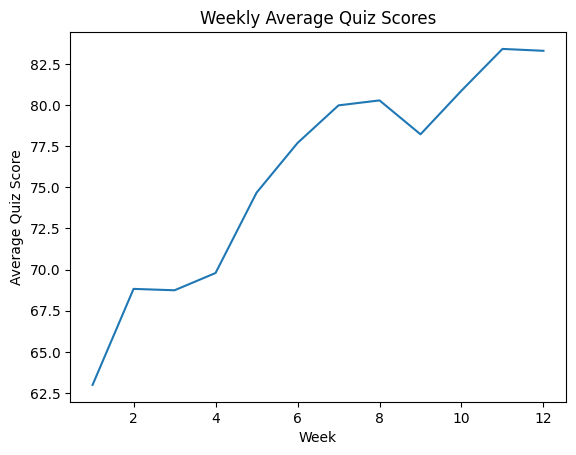

In [3]:

plt.figure()
plt.plot(quiz_df['week'], quiz_df['avg_quiz_score'])
plt.title('Weekly Average Quiz Scores')
plt.xlabel('Week')
plt.ylabel('Average Quiz Score')
plt.show()



## 2) Bar Chart — Compare Categories

**Use when:** Comparing **discrete categories** or counts/means per category.  
**Tells us:** Which categories are larger/smaller, relative differences, ranking.  
**Pitfalls:** Too many categories become hard to read; start the axis at zero for counts and magnitudes.


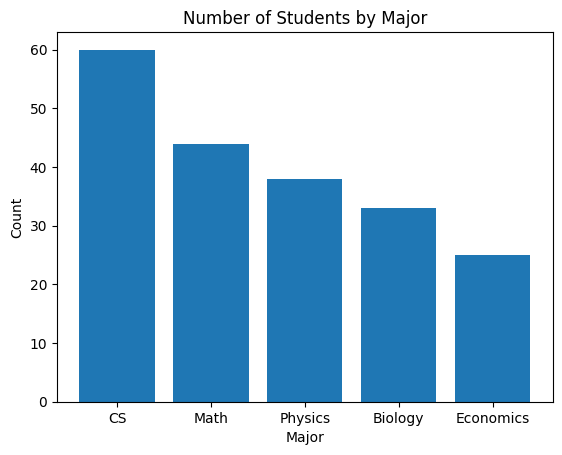

In [4]:

# Example: Count students by major
counts = data['major'].value_counts().sort_values(ascending=False)

plt.figure()
plt.bar(counts.index, counts.values)
plt.title('Number of Students by Major')
plt.xlabel('Major')
plt.ylabel('Count')
plt.show()



## 3) Histogram — Distribution Shape

**Use when:** You want the **shape of a single variable** (unimodal? skewed? multi-modal?).  
**Tells us:** Center, spread, skewness, outliers, multi-modality.  
**Pitfalls:** Bin choice matters; try multiple bin widths; avoid comparing many groups in one histogram.


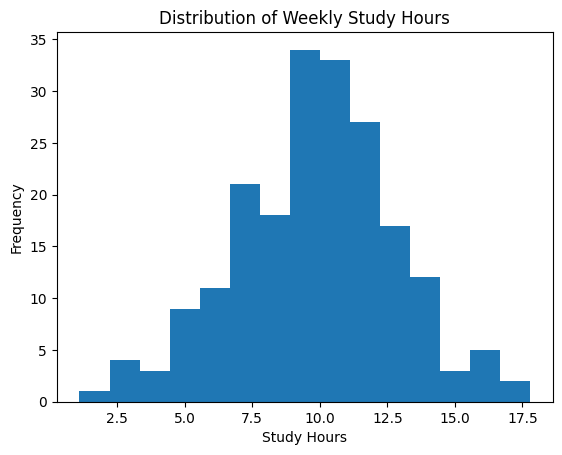

In [5]:

plt.figure()
plt.hist(data['study_hours'], bins=15)
plt.title('Distribution of Weekly Study Hours')
plt.xlabel('Study Hours')
plt.ylabel('Frequency')
plt.show()



## 4) Box Plot — Spread, Quartiles, Outliers

**Use when:** Comparing **distributions across groups** succinctly.  
**Tells us:** Median, interquartile range (IQR), whiskers, and outliers. Good for group comparisons.  
**Pitfalls:** Doesn’t show multi-modality or exact distribution shape — pair with histograms when needed.


/var/folders/xb/7lc6cd4x4z54j1yjyx373gz00000gn/T/ipykernel_1460/896639995.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=labels, showfliers=True)


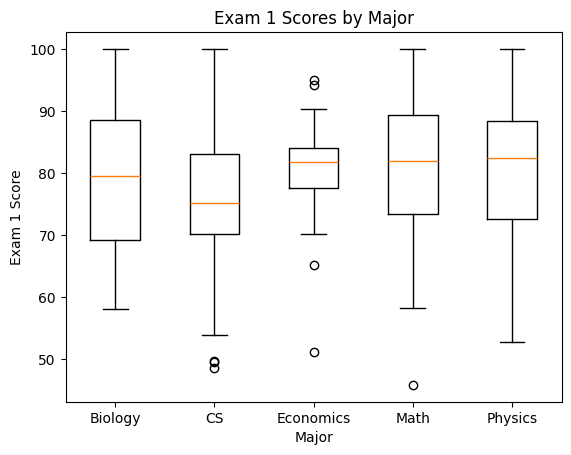

In [6]:

# Box plot: Exam 1 scores by major
grouped = [grp['exam1'].values for _, grp in data.groupby('major')]
labels = list(data.groupby('major').groups.keys())

plt.figure()
plt.boxplot(grouped, labels=labels, showfliers=True)
plt.title('Exam 1 Scores by Major')
plt.xlabel('Major')
plt.ylabel('Exam 1 Score')
plt.show()



## 5) Scatter Plot — Relationship Between Two Variables

**Use when:** Exploring **association/correlation** between two numeric variables.  
**Tells us:** Direction (positive/negative), form (linear/nonlinear), strength, and outliers.  
**Pitfalls:** Overplotting in large datasets; correlation ≠ causation.


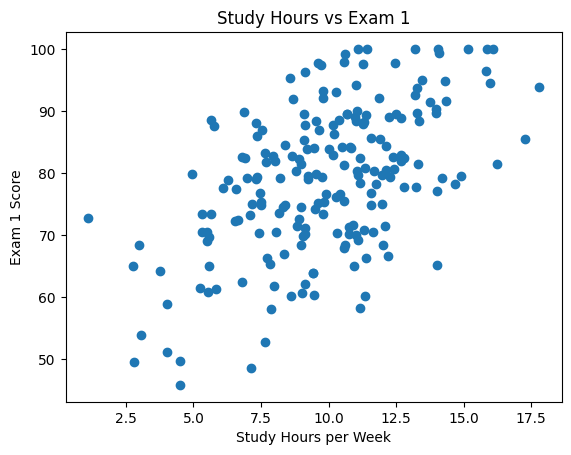

Pearson correlation (study_hours, exam1): 0.53


In [7]:

plt.figure()
plt.scatter(data['study_hours'], data['exam1'])
plt.title('Study Hours vs Exam 1')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam 1 Score')
plt.show()

# Quick numeric summary: correlation
corr = np.corrcoef(data['study_hours'], data['exam1'])[0,1]
print(f"Pearson correlation (study_hours, exam1): {corr:.2f}")



## 6) Stacked Bar — Composition Within Categories

**Use when:** Showing **subgroup composition** within categories.  
**Tells us:** Part-to-whole within each category; relative contributions.  
**Pitfalls:** Hard to compare subcomponents across categories (except the base segment).


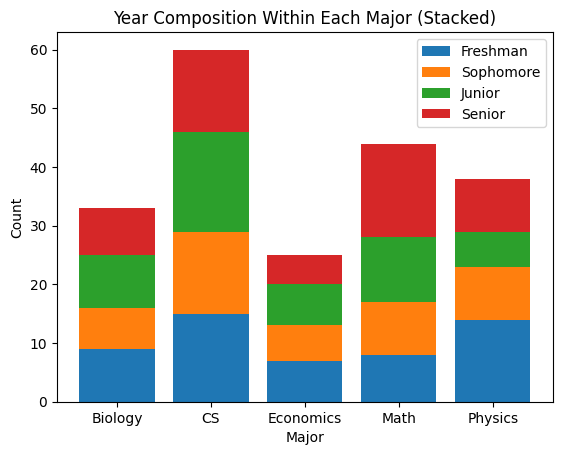

In [8]:

# Composition of class year within each major
comp = (data
        .groupby(['major', 'year'])
        .size()
        .unstack(fill_value=0)
        .loc[:, ['Freshman','Sophomore','Junior','Senior']])

# Build stacked bars manually (wide -> stacked)
plt.figure()
bottom = np.zeros(len(comp))
for col in comp.columns:
    plt.bar(comp.index, comp[col].values, bottom=bottom, label=col)
    bottom = bottom + comp[col].values

plt.title('Year Composition Within Each Major (Stacked)')
plt.xlabel('Major')
plt.ylabel('Count')
plt.legend()
plt.show()



## 7) Pie Chart — Proportions of a Whole (Use Sparingly)

**Use when:** A **small number of categories** and you want a **single part-to-whole** snapshot.  
**Tells us:** Proportion of each category.  
**Pitfalls:** Hard to compare slice sizes accurately; bar charts are often better.


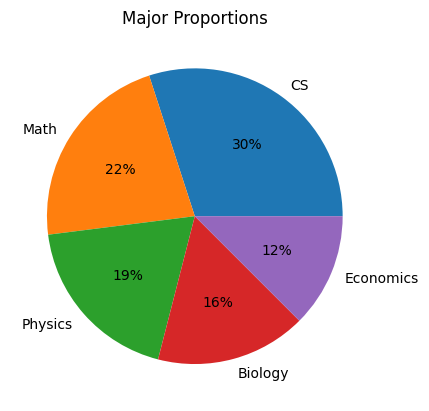

In [9]:

# Overall major proportions (small number of categories)
major_props = data['major'].value_counts(normalize=True).sort_values(ascending=False)

plt.figure()
plt.pie(major_props.values, labels=major_props.index, autopct='%1.0f%%')
plt.title('Major Proportions')
plt.show()



## 8) Heatmap (Correlation Matrix) — Many Relationships at Once

**Use when:** You want a compact view of **pairwise relationships** across several numeric variables.  
**Tells us:** Which variables move together (positive/negative correlation), and relative strength.  
**Pitfalls:** Correlation ≠ causation; values can be sensitive to outliers.


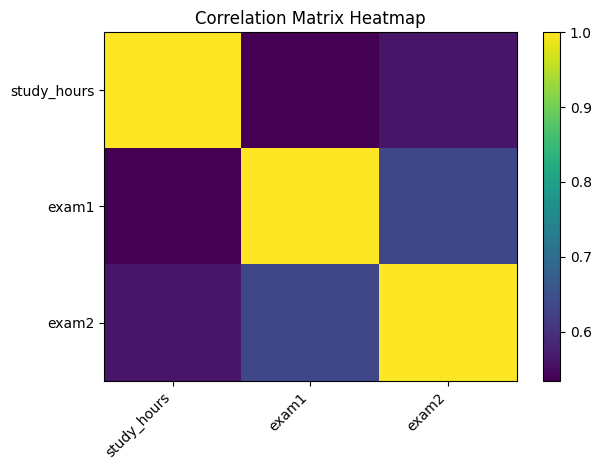

,study_hours,exam1,exam2
study_hours,1.000000,0.534485,0.562877
exam1,0.534485,1.000000,0.632938
exam2,0.562877,0.632938,1.000000


In [10]:

# Compute correlation matrix
num_cols = ['study_hours', 'exam1', 'exam2']
corr = data[num_cols].corr()

# Simple heatmap with imshow (no external libs)
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

corr



## Teaching Tips & Pitfalls (Quick Reference)

- **Line vs Bar:** Use line for time/ordered sequences; bar for unordered categories.
- **Hist vs Box:** Use histogram to show *shape*; box plots to compare groups quickly.
- **Scatter:** Emphasize that correlation does not imply causation. Discuss outliers.
- **Stacked Bars:** Great for within-category composition; not great for comparing subgroups across categories.
- **Pie:** Limit to a few categories; otherwise use a bar chart.
- **Heatmaps:** Encourage students to read both the colors and the numeric values.

**Scaling/axes:** Be transparent about axis ranges and zero baselines for magnitude comparisons.  
**Overplotting:** In large datasets, demonstrate jitter or transparency (alpha) and note trade-offs.



## Mini Case Study — Telling a Story with Multiple Plots

**Question:** *Do students who study more perform better, and has the class improved over time?*

**Approach:**
1. **Scatter** — Study hours vs Exam 1.
2. **Line** — Weekly quiz average over time.
3. **Box** — Exam 1 by major (are there group differences?).
4. **Heatmap** — Correlations among key metrics.


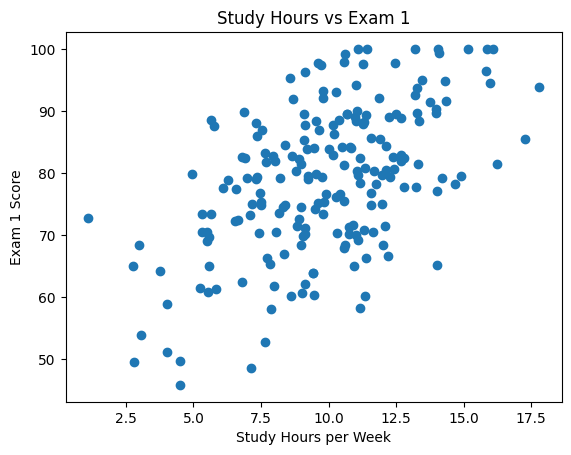

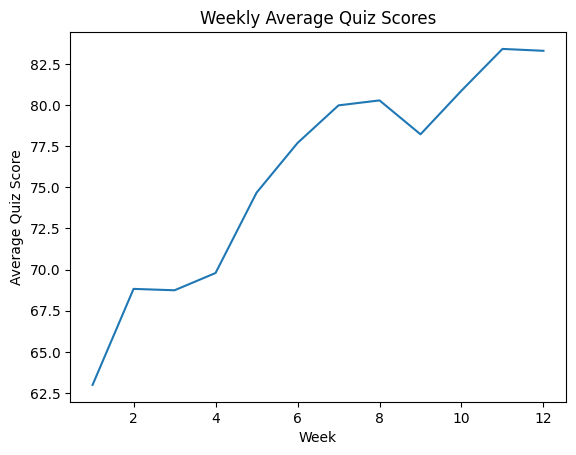

/var/folders/xb/7lc6cd4x4z54j1yjyx373gz00000gn/T/ipykernel_1460/4075241348.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=labels, showfliers=True)


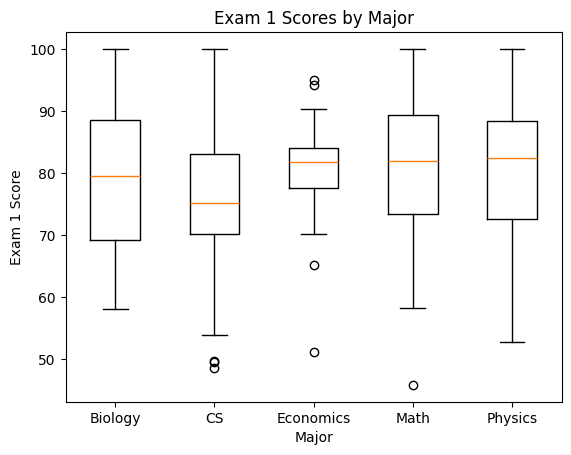

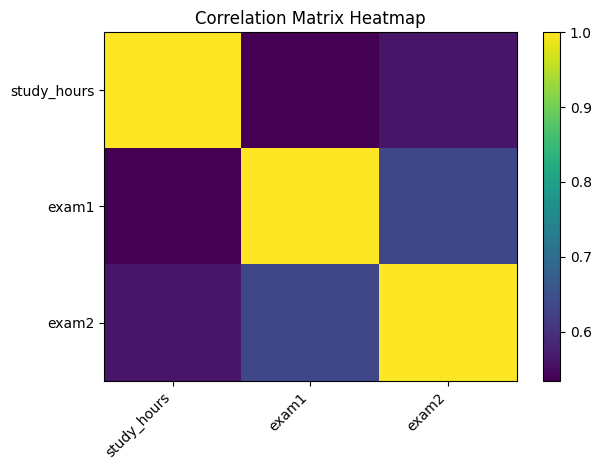

In [11]:

# 1) Scatter: study vs performance
plt.figure()
plt.scatter(data['study_hours'], data['exam1'])
plt.title('Study Hours vs Exam 1')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam 1 Score')
plt.show()

# 2) Line: progress over time
plt.figure()
plt.plot(quiz_df['week'], quiz_df['avg_quiz_score'])
plt.title('Weekly Average Quiz Scores')
plt.xlabel('Week')
plt.ylabel('Average Quiz Score')
plt.show()

# 3) Box: differences across majors
grouped = [grp['exam1'].values for _, grp in data.groupby('major')]
labels = list(data.groupby('major').groups.keys())

plt.figure()
plt.boxplot(grouped, labels=labels, showfliers=True)
plt.title('Exam 1 Scores by Major')
plt.xlabel('Major')
plt.ylabel('Exam 1 Score')
plt.show()

# 4) Heatmap: correlation
num_cols = ['study_hours', 'exam1', 'exam2']
corr = data[num_cols].corr()
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()



## Exercises (Use or Assign)

1. **Bin Sensitivity:** Re-plot the histogram of `study_hours` with 5, 10, 30 bins. How does interpretation change?
2. **Grouped Bar:** Create a grouped (side-by-side) bar chart of **mean `exam1` by `major`**.
3. **Outliers:** Identify students with `exam1` < 40 and annotate them on the scatter plot.
4. **Trend Line:** Fit a simple linear regression line on the scatter (without external libraries: use `np.polyfit`) and interpret.
5. **Subsetting:** Compare distributions of `exam2` for freshmen vs seniors with two box plots.


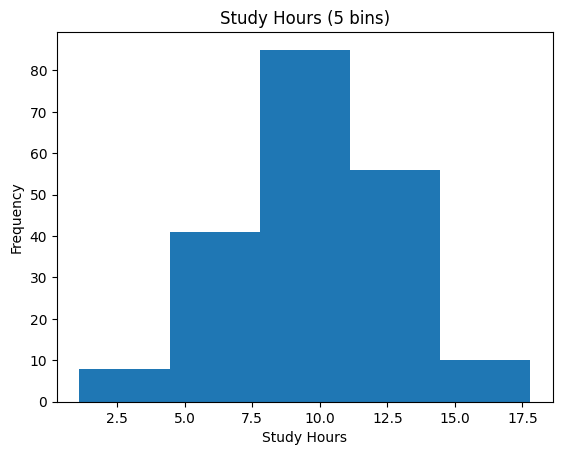

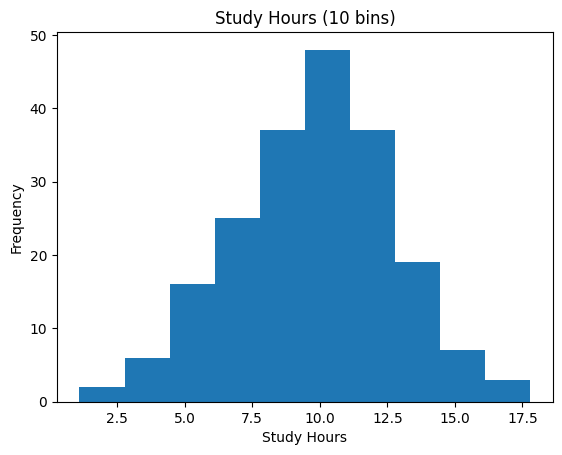

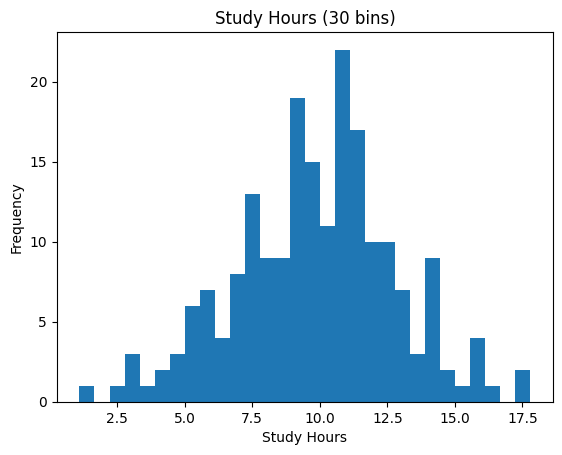

In [12]:

# 1) Bin sensitivity
plt.figure()
plt.hist(data['study_hours'], bins=5)
plt.title('Study Hours (5 bins)')
plt.xlabel('Study Hours')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(data['study_hours'], bins=10)
plt.title('Study Hours (10 bins)')
plt.xlabel('Study Hours')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(data['study_hours'], bins=30)
plt.title('Study Hours (30 bins)')
plt.xlabel('Study Hours')
plt.ylabel('Frequency')
plt.show()


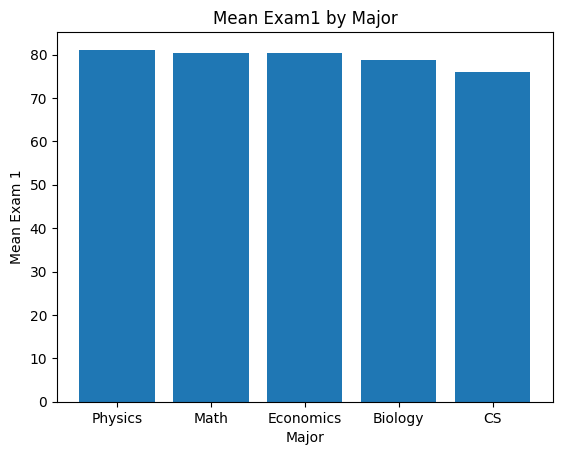

In [13]:

# 2) Grouped bar: mean exam1 by major
means = data.groupby('major')['exam1'].mean().sort_values(ascending=False)
plt.figure()
plt.bar(means.index, means.values)
plt.title('Mean Exam1 by Major')
plt.xlabel('Major')
plt.ylabel('Mean Exam 1')
plt.show()


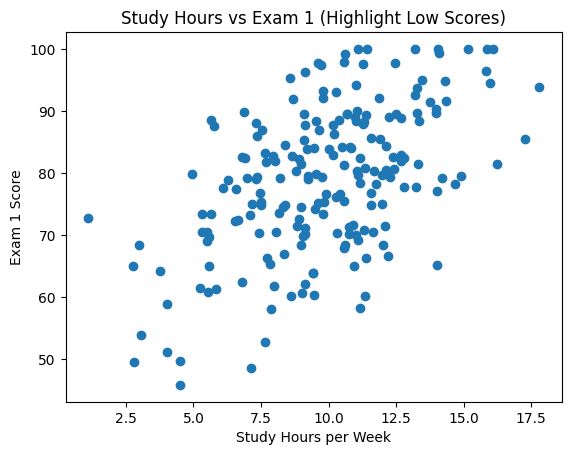

In [14]:

# 3) Outliers and annotations on scatter
low_idx = data['exam1'] < 40
plt.figure()
plt.scatter(data['study_hours'], data['exam1'])
plt.title('Study Hours vs Exam 1 (Highlight Low Scores)')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam 1 Score')
# annotate a few (limit to 5 for readability)
for i, row in data[low_idx].head(5).iterrows():
    plt.annotate(str(int(row['student_id'])), (row['study_hours'], row['exam1']))
plt.show()


Fitted line: y = 2.11x + 58.22


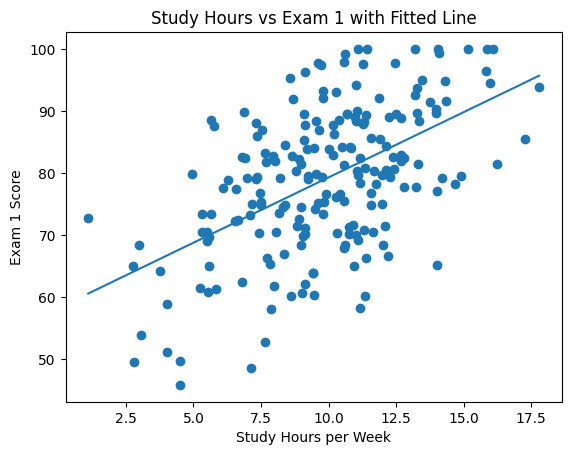

In [15]:

# 4) Simple linear regression line with numpy
x = data['study_hours'].values
y = data['exam1'].values
m, b = np.polyfit(x, y, 1)
print(f"Fitted line: y = {m:.2f}x + {b:.2f}")

plt.figure()
plt.scatter(x, y)
plt.plot(np.sort(x), m*np.sort(x) + b)  # plot line over sorted x
plt.title('Study Hours vs Exam 1 with Fitted Line')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam 1 Score')
plt.show()


/var/folders/xb/7lc6cd4x4z54j1yjyx373gz00000gn/T/ipykernel_1460/1187702168.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=['Freshman','Senior'])


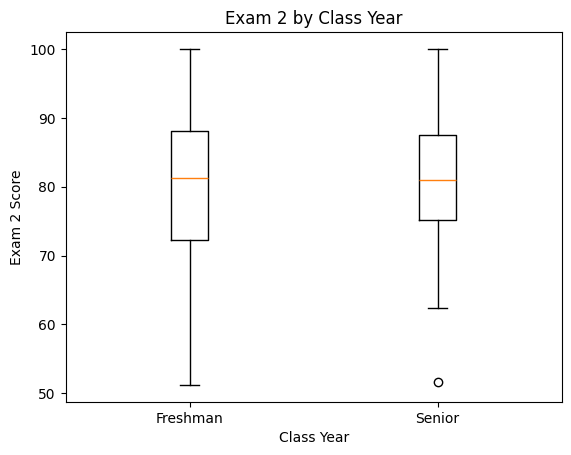

In [16]:

# 5) Box plots for freshmen vs seniors (exam2)
subset = data[data['year'].isin(['Freshman', 'Senior'])]
grouped = [subset[subset['year']==y]['exam2'] for y in ['Freshman','Senior']]

plt.figure()
plt.boxplot(grouped, labels=['Freshman','Senior'])
plt.title('Exam 2 by Class Year')
plt.xlabel('Class Year')
plt.ylabel('Exam 2 Score')
plt.show()



## Quick Reference — Which Plot for Which Question?

| Question you’re asking | Best first-choice plot | Alternatives |
|---|---|---|
| How did a metric change over time? | Line plot | Area plot |
| Which category is larger? | Bar chart | Dot plot |
| What is the distribution shape? | Histogram | Box plot, KDE |
| How do groups differ in distribution? | Box plot | Violin plot |
| Are two variables related? | Scatter | Hexbin (large n) |
| What’s the composition within categories? | Stacked bar | 100% stacked bar |
| What relationships exist across many variables? | Correlation heatmap | Pair plot |

Use this to guide students in selecting **the right chart for the question**.



---

**End of notebook.** Feel free to duplicate cells, change datasets, or adapt the narrative to your course.

